Bibliotecas:

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

Arquivo:

In [8]:
#obtendo arquivo
url_arquivo = 'https://raw.githubusercontent.com/mf-gueiros/_sandbox/main/01%20-%20%20CustomerChurn/telecomChurn.csv'

In [9]:
#informação das colunas
df = pd.read_csv(url_arquivo)
print(df.head())
print(df.info())

   Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1        2.7              1   
1      0           107                1         1        3.7              1   
2      0           137                1         0        0.0              0   
3      0            84                0         0        0.0              2   
4      0            75                0         0        0.0              3   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------ 

Abaixo, temos o dicionário de dados para os registros do csv fornecido:

Churn: 1 - consumidor cancelou o serviço / 0 - não cancelou 

AccountWeeks: Número de semanas que o consumidor teve uma conta ativa

ContractRenewal: 1 - consumidor renovou o contrato recentemente / 0 - não

DataPlan: 1 - consumidor tem um plano de dados / 0 - não

DataUsage: Gigabytes usados por mês

CustServCalls: Quantidade de ligações feitas para o serviço de atendimento ao cliente

DayMins: Média de minutos usados durante o dia por mês

DayCalls: Média de ligações feitas durante o dia por mês

MonthlyCharge: Valor médio da fatura mensal

OverageFee: Maior taxa de excesso incorrida nos últimos 12 meses

RoamMin: Número total de minutos que o cliente passa usando o telefone em roaming

In [10]:
#Análise de dados faltantes
missing_data = df.isnull().sum()
print("Missing values in each column:")
print(missing_data)

Missing values in each column:
Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64


Observado que não faltam dados em nenhuma das colunas.

In [11]:
#removendo os dados binários para análise de numéricos
df_numeric = df.drop(['Churn', 'DataPlan', 'ContractRenewal'], axis=1)

#resumo dos dados numéricos
df_numeric.describe()

,AccountWeeks,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,39.822106,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,74.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,101.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,127.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,243.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


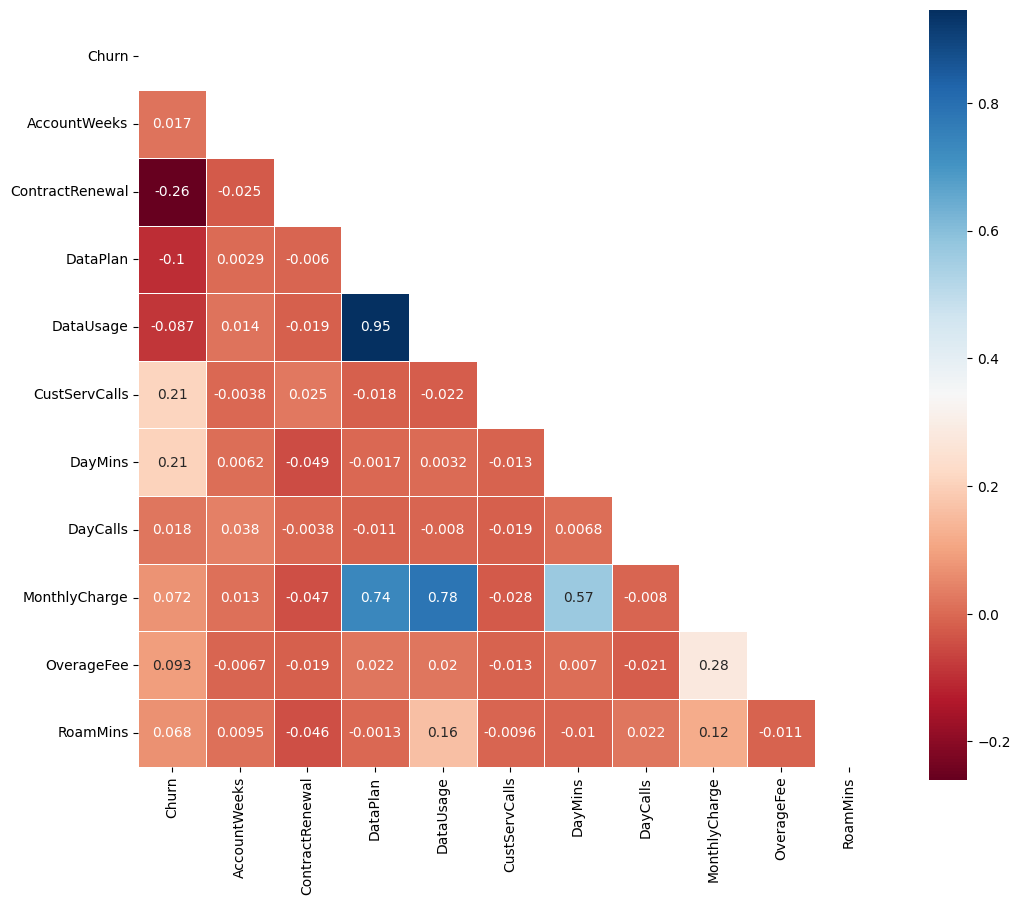

In [12]:
#matriz de correlação
corr = df.corr()

#mask para limitar o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

#tamanho do plot
plt.figure(figsize=(12, 10))

#heatmap com a mask para exibir apenas o triangulo inf
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', square=True, linewidths=0.5)

#plotando
plt.show()

## Correlações:

----
### Churn                                        

x ContractRenewal: Apresenta correl. negativa (-0.26) -> consumidores que renovaram os contratos recentemente tendem a ter menos Churn.

x CustomerServiceCalls: Correlação positiva (0.21) -> consumidores que fazem mais ligações para o serviço tendemciam mais a cancelar o serviço

x DayMins: Correl. positiva (0.21) -> mais uso de minutos por dia indicam maior probabilidade de Churn

x MonthlyCharge: Correl. positiva (0.07) -> consumidores com maiores recargas mensais tendem a ter maior churn (todavia com relação fraca)

x OverageFee: Correl. positiva (0.09) -> maiores taxas excedentes indicam leve inclinação à ocorrência de Churn.

----


### Inter-Campos                                       

DataPlan x DataUsage: correlação positiva forte (0,95) entre ter um plano e usar muitos dados -> faz sentido, do ponto de vista analítico, pois clientes com mais planos tendem a usar mais dados

DataUsage e MonthlyCharge: correlação positiva forte (0,78) entre o uso de dados e a cobrança mensal -> maior consumo de dados implica cobranças mensais mais altas

DayMins e DayCalls: correlação positiva moderada (0,57) entre minutos diurnos e chamadas diurnas -> sugerindo que os clientes que fazem mais chamadas também tendem a ter mais minutos

MonthlyCharge e OverageFee: correlação positiva moderada (0,28) entre cobranças mensais e taxas de excedente -> indicando que cobranças mensais mais altas podem ser parcialmente devido a taxas de excedente.

----

### Conclusões-chave                                        

ContractRenewal e CustServCalls são recursos importantes a serem considerados para prever a rotatividade devido às suas correlações relativamente mais fortes.

DataUsage e DataPlan têm alta correlação entre sí, sugerindo redundância. Pode valer a pena considerar se ambos os recursos são necessários para o modelo ou se um pode ser derivado do outro.

Embora recursos como MonthlyCharge e OverageFee mostrem alguma correlação com a rotatividade, seus relacionamentos são fracos, sugerindo que eles podem não ser preditores fortes por si só, mas podem contribuir para um modelo preditivo em combinação com outros recursos.                          

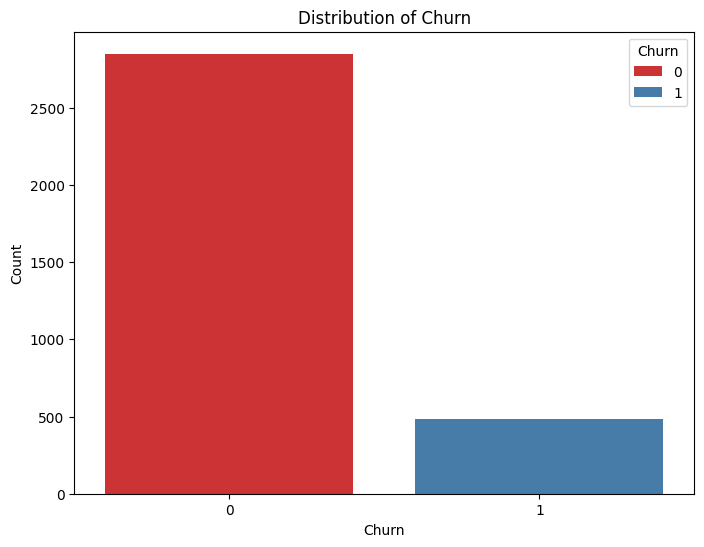

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df, hue='Churn', palette='Set1', dodge=False)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.show()


### Análise da distribuição: 
Grande parte dos clientes listados na base não deixaram a empresa/serviço (churn = 0). Esta análise sugere que é o churn é menos frequente e isso deve estar contido no treinamento do modelo

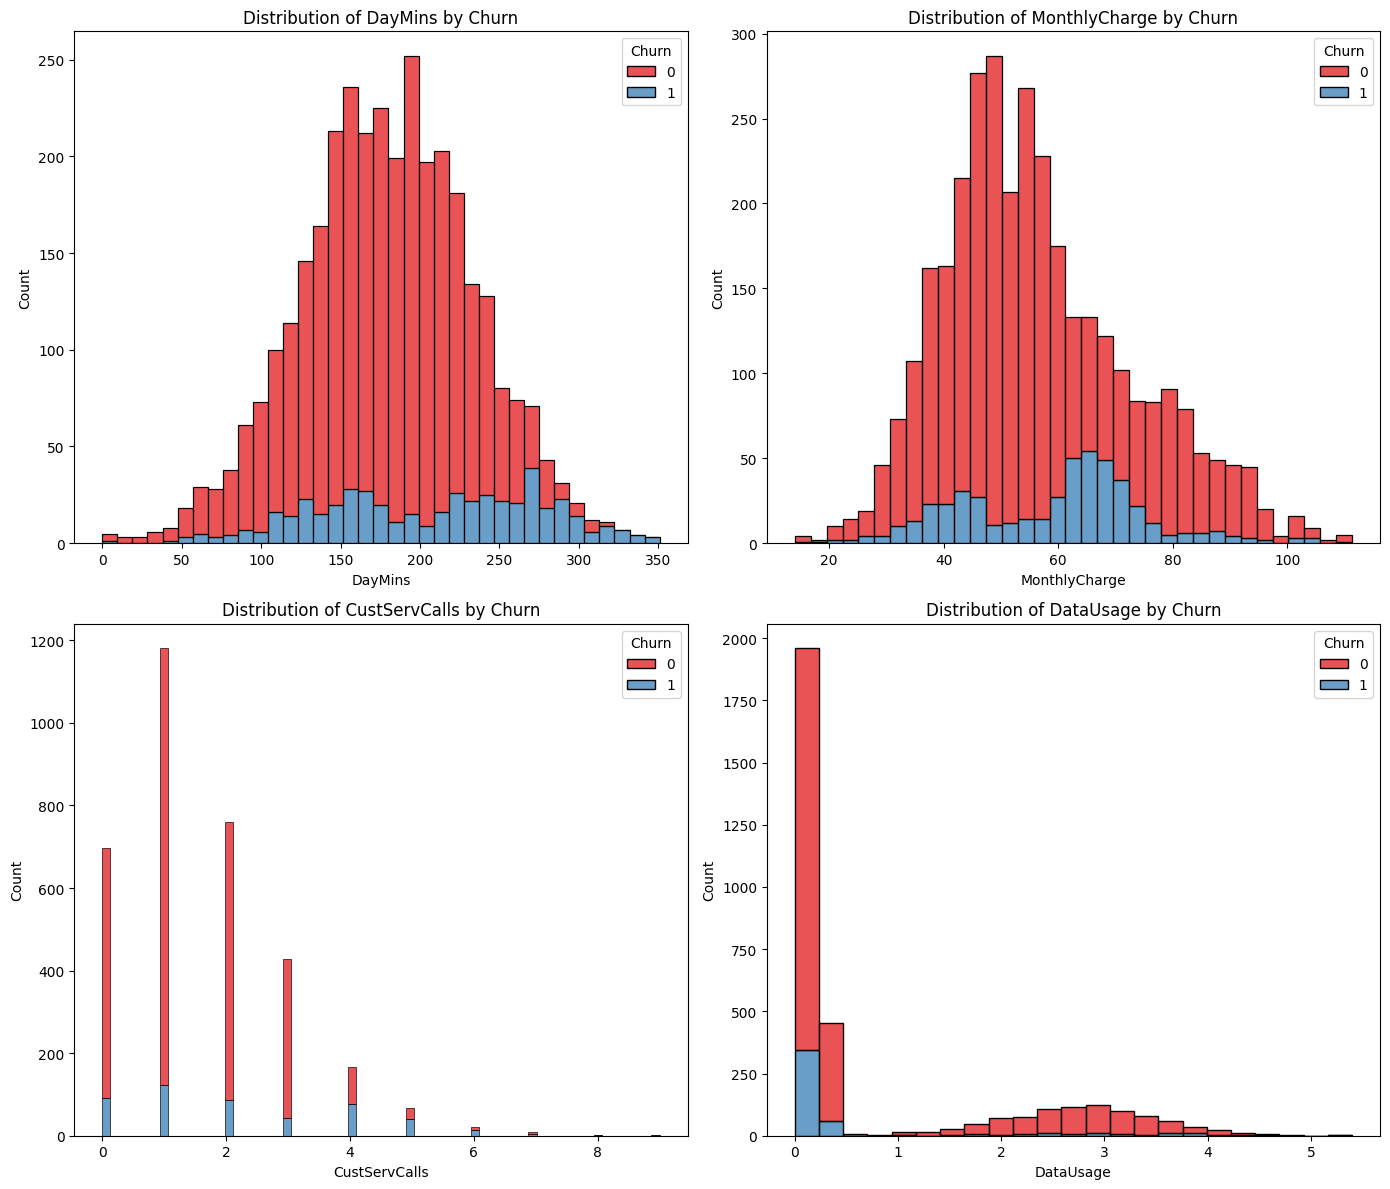

In [14]:
# Suprimindo alertas específicos
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Tratando infinitos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Setando figura do matplotlib
plt.figure(figsize=(14, 12))

# média de tempo diário por mês
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='DayMins', hue='Churn', multiple='stack', palette='Set1')
plt.title('Distribution of DayMins by Churn')

# média de valor mensal
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='MonthlyCharge', hue='Churn', multiple='stack', palette='Set1')
plt.title('Distribution of MonthlyCharge by Churn')

# ligações para o atendimento
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='CustServCalls', hue='Churn', multiple='stack', palette='Set1')
plt.title('Distribution of CustServCalls by Churn')

# Dados mensais usados (GB)
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='DataUsage', hue='Churn', multiple='stack', palette='Set1')
plt.title('Distribution of DataUsage by Churn')

plt.tight_layout()
plt.show()

### **Análise da distribuição das variáveis x Churn**

DayMins X Churn: A distribuição dos minutos de uso é bastante uniforme para ambos os grupos, churned e não churned, com um pico em torno de 150 a 200 minutos. Clientes que deixaram a empresa tendem a utilizar um pouco mais os minutos diurnos, mas a diferença não é marcante. Isso sugere que o uso de minutos diurnos, por si só, não é um preditor significativo de churn, embora um uso maior possa estar associado a um risco ligeiramente maior de churn.

CustServCalls x Churn: a maioria dos clientes que permanecem na empresa (churn = 0) fez poucas chamadas (entre 1 e 2). Clientes que deixaram a empresa tendem a ter feito maior número de chamadas ao serviço de atendimento (entre 3-4 chamadas). Maior número de chamadas pode estar relacionado à insatisfação, aumentando o churn.

DataUsage x Churn: grande maioria dos clientes tem baixo volume de uso dos dados (0-1 GB). Clientes com maior uso de dados aumentam a taxa de Churn de forma leve. No entanto, por sí só este campo não é relevante na previsão do churn, sendo necessário incluir outros fatores na análise para ter maior precisão.

Distribuição de MonthlyCharge por Churn: Distribuição normal para ambos os grupos (churn ou não) com um pico em torno de 50 a 60. Clientes que deixaram a empresa tendem a ter cobranças mensais mais altas em comparação com aqueles que não deixaram. Cobranças mensais mais altas -> podem contribuir para insatisfação, aumentando a probabilidade de churn.

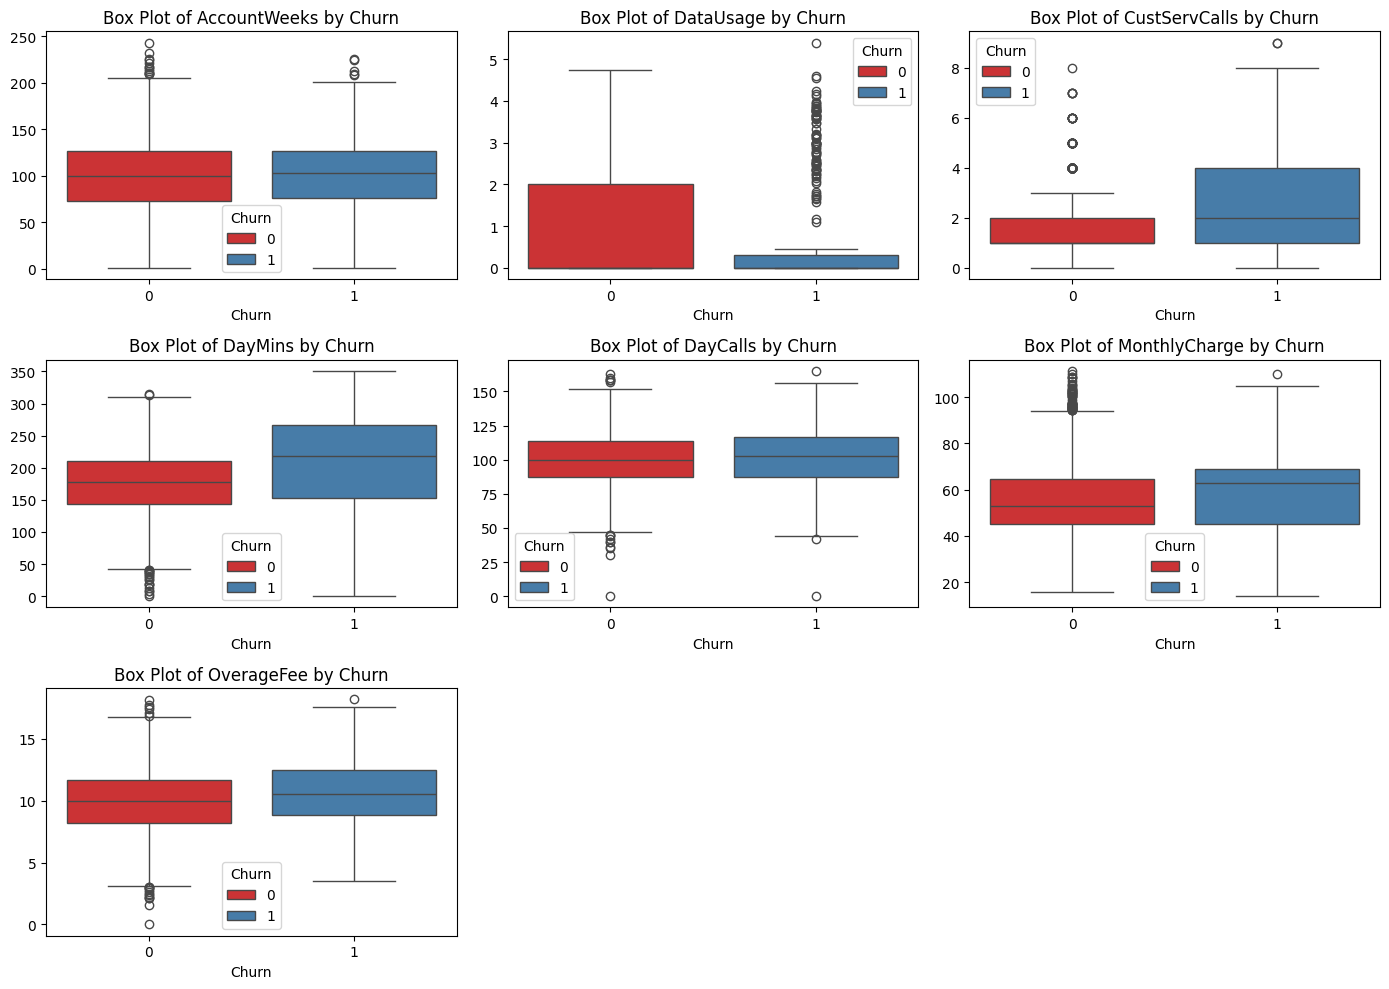

In [15]:
numerical_features = ['AccountWeeks', 'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, x='Churn', y=feature, hue='Churn', palette='Set1', dodge=False)
    plt.title(f'Box Plot of {feature} by Churn')
    plt.xlabel('Churn')
    plt.ylabel('')

plt.tight_layout()
plt.show()


### **Análise dos BoxPlot**


AccountWeeks X Churn: A mediana do tempo ativo da conta é ligeiramente maior para clientes que não deixaram a empresa/serviço em comparação com aqueles que deixaram. Isso sugere que uma maior duração da conta pode estar associada a uma menor probabilidade de churn. No entanto, a dispersão geral é semelhante para ambos os grupos.

DataUsage X Churn: Clientes que não deixaram a empresa/serviço tendem a ter um uso de dados mais alto, conforme indicado pela mediana mais alta e pela faixa interquartil mais ampla. O uso de dados dos clientes que deixaram a empresa é mais baixo e mais concentrado. Isso sugere que um menor uso de dados pode ser um indicador de churn.

CustServCalls X Churn: O número de chamadas ao serviço de atendimento é notavelmente maior para clientes que deixaram a empresa/serviço, com uma mediana mais alta e um maior número de outliers. Isso sugere que um maior volume de chamadas ao serviço de atendimento está associado a uma maior probabilidade de churn, possivelmente devido à insatisfação.

DayMins X Churn: A distribuição de minutos diurnos usados por mês é semelhante para os dois grupos. No entanto, clientes que deixaram a empresa apresentam uma mediana de uso ligeiramente maior. Isso indica que o uso de minutos diurnos por si só pode não ser um forte preditor de churn.

DayCalls X Churn: A distribuição de chamadas diurnas é bastante similar entre os dois tipos de clientes, sem diferença significativa nas medianas ou na dispersão. Isso sugere que o número de chamadas diurnas não é um forte indicador de churn.

MonthlyCharge X Churn: Clientes com churn = 1 tendem a ter cobranças mensais mais altas, conforme indicado pela mediana mais alta e pela faixa interquartil mais ampla. Isso sugere que cobranças mensais mais altas podem contribuir para insatisfação e, consequentemente, para uma maior probabilidade de churn.

OverageFee X Churn: A distribuição das taxas de excesso é ligeiramente mais alta para clientes que deixaram a empresa, com uma mediana mais alta e mais outliers. Isso sugere que taxas de excesso mais altas podem estar associadas a uma maior probabilidade de churn, possivelmente devido à insatisfação dos clientes com cobranças inesperadas.


----
## **Início da Preparação dos dados**

Abaixo, foi criada uma feature derivada, para entender se há alguma influência do comportamento do tempo médio de duração das chamadas na ocorrência de churn pelo cliente.

In [16]:
# Duração media da ligação
df['AvgCallDuration'] = df['DayMins'] / df['DayCalls']

# Replace resultados infinitos da div/0
df['AvgCallDuration'] = df['AvgCallDuration'].replace([np.inf, -np.inf], 0)

# Verificando nova construção
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,AvgCallDuration
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0,2.410000
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7,1.313821
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2,2.135088
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6,4.216901
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1,1.475221


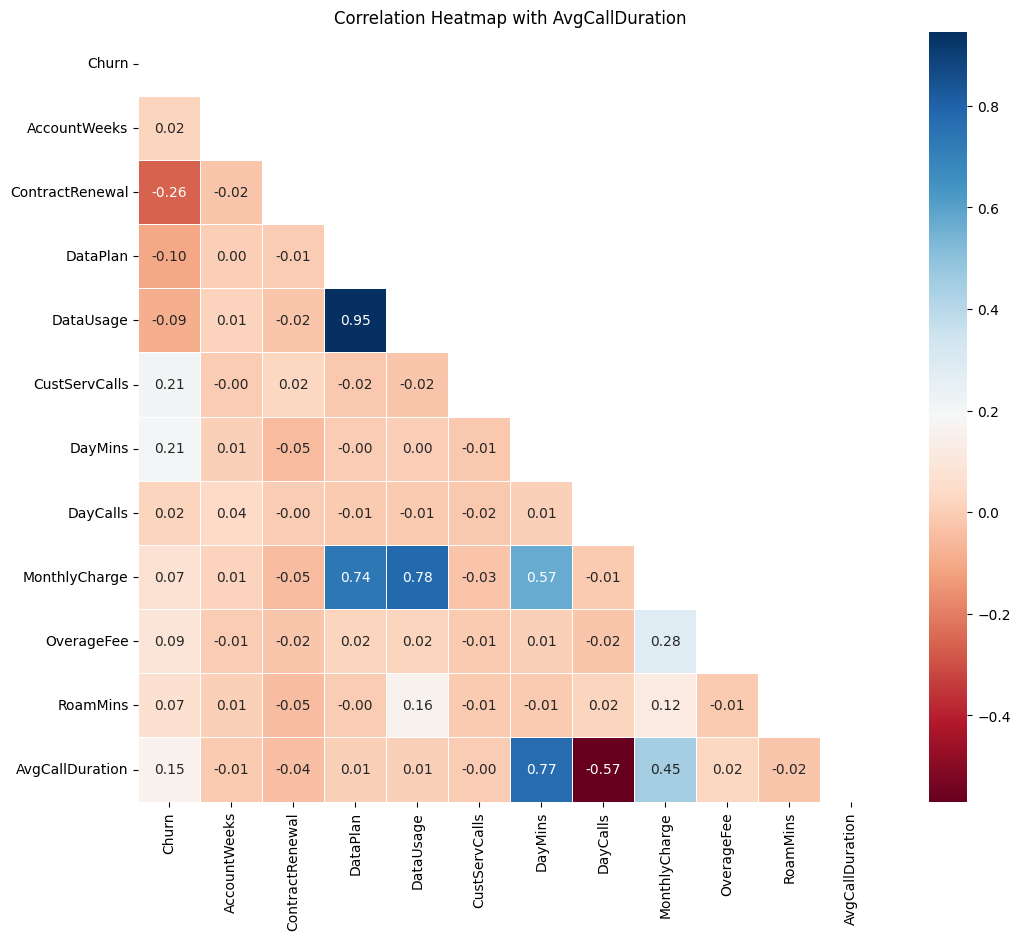

In [17]:
# Incluindo duração media da ligação no mapa de correlação
correlation_matrix = df[['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'AvgCallDuration']].corr()

#mask para limitar o triângulo superior
mask2 = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotando
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask2, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap with AvgCallDuration')
plt.show()

Observamos uma correlação positiva fraca de 0,15 -> sugere que clientes com durações médias de chamadas mais longas podem ter uma ligeira tendência a deixarem a empresa.

----

Abaixo, são selecionadas as características para o modelo com base na análise exploratória e nas novas características derivadas. Incluímos atributos originais e novas variáveis, como a AvgCallDuration.

Decidimos incluir apenas o Plano de Dados (DataPlan) e excluir o Uso de Dados (DataUsage) devido à alta correlação entre eles (0,95). Isso evita redundância e reduz a dimensionalidade do conjunto de dados, simplificando o modelo sem perder poder preditivo.

In [18]:
# Escolhendo as colunas para o EDA
features = ['AccountWeeks', 'ContractRenewal', 'DataPlan', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'AvgCallDuration']
target = 'Churn'

# Separando features de targets
X = df[features]
y = df[target]

In [19]:
# Verificando os valores NaN values no dataset
nan_counts = df[features].isnull().sum()
print("NaN values in each column of the original dataset:")
print(nan_counts)

# Lidando com os valores NaN - substituindo pela média
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Verificando se o input removeu os NaN
X_df_imputed = pd.DataFrame(X, columns=features)
nan_counts_imputed = X_df_imputed.isnull().sum()
print("NaN values in each column of the imputed dataset:")
print(nan_counts_imputed)

NaN values in each column of the original dataset:
AccountWeeks       0
ContractRenewal    0
DataPlan           0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
AvgCallDuration    2
dtype: int64
NaN values in each column of the imputed dataset:
AccountWeeks       0
ContractRenewal    0
DataPlan           0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
AvgCallDuration    0
dtype: int64


Após a criação do campo derivado, foi verificado que houveram dois valores NAN. Efetuada a substituição destes valores pela média da coluna.

In [20]:
# Padronizando os features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertendo os dados padronizados para um DataFrame para facilitar a manipulação
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=45)

# Exibindo as formas dos conjuntos resultantes
print(f'Training set shape: X={X_train.shape}, y={y_train.shape}')
print(f'Testing set shape: X={X_test.shape}, y={y_test.shape}')

Training set shape: X=(2666, 10), y=(2666,)
Testing set shape: X=(667, 10), y=(667,)


No bloco acima, foram padronizados os dados dos recursos usando o StandardScaler, ajustando-os para média zero e desvio padrão um, para garantir que todos os recursos contribuam igualmente ao modelo. Em seguida, dividimos os dados padronizados em conjuntos de treinamento (80%) e teste (20%) com o método train_test_split, utilizando definindo o random_state para garantir a reprodutibilidade. O conjunto de treinamento contém 2.666 amostras e o de teste 667, ambos com 12 recursos.

---- 
## Construção do modelo        
                                                                                
                                                                                
Nesta seção, serão construídos e avaliados modelos de aprendizado de máquina para prever a rotatividade de clientes.

Iniciando com o classificador Random Forest e depois com o classificador Gradient Boosting para comparação. Cada modelo é treinado no conjunto de dados de treinamento e avaliado no conjunto de dados de teste.

In [21]:
# Definindo o espaço dos hiperparâmetros
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inicializando o modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Inicializando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_distributions, 
    n_iter=50,  # Número de combinações aleatórias
    cv=3,  # Divisões de Validação Cruzada
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Realizando a busca aleatória
random_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros e a melhor acurácia
print("Melhores parâmetros encontrados: ", random_search.best_params_)
print("Melhor acurácia encontrada: ", random_search.best_score_)

# Realizando previsões com o melhor modelo
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Avaliando o modelo
print("Modelo Random Forest com Otimização de Hiperparâmetros")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\mf_gu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros encontrados:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Melhor acurácia encontrada:  0.9347353540266926
Modelo Random Forest com Otimização de Hiperparâmetros
Acurácia: 0.9385307346326837
Matriz de Confusão:
 [[564   8]
 [ 33  62]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       572
           1       0.89      0.65      0.75        95

    accuracy                           0.94       667
   macro avg       0.92      0.82      0.86       667
weighted avg       0.94      0.94      0.93       667



In [22]:
# Modelo sem otimização de parâmetros
# Inicializa o modelo Random Forest
rf_no_opt = RandomForestClassifier(random_state=42, n_estimators=100)

# Treina o modelo
rf_no_opt.fit(X_train, y_train)

# Faz previsões
y_pred_rf_no_opt = rf_no_opt.predict(X_test)

# Avalia o modelo
print("\nModelo Random Forest sem Otimização de Hiperparâmetros")
print("\nAcurácia:", accuracy_score(y_test, y_pred_rf_no_opt))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf_no_opt))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf_no_opt))


Modelo Random Forest sem Otimização de Hiperparâmetros

Acurácia: 0.9355322338830585

Matriz de Confusão:
 [[564   8]
 [ 35  60]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       572
           1       0.88      0.63      0.74        95

    accuracy                           0.94       667
   macro avg       0.91      0.81      0.85       667
weighted avg       0.93      0.94      0.93       667



In [23]:
# Inicializa o modelo Gradient Boosting
gb = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Treina o modelo
gb.fit(X_train, y_train)

# Faz previsões
y_pred_gb = gb.predict(X_test)

# Avalia o modelo
print("Modelo Gradient Boosting")
print("\nAcurácia:", accuracy_score(y_test, y_pred_gb))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_gb))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_gb))


Modelo Gradient Boosting

Acurácia: 0.9400299850074962

Matriz de Confusão:
 [[563   9]
 [ 31  64]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       572
           1       0.88      0.67      0.76        95

    accuracy                           0.94       667
   macro avg       0.91      0.83      0.86       667
weighted avg       0.94      0.94      0.94       667



## Modelos de Machine Learning Utilizados

### Random Forest Classifier
Foi escolhido o **Random Forest** porque é um método de ensemble que reduz o risco de overfitting ao combinar múltiplas árvores de decisão. Ele lida bem com grandes conjuntos de dados e consegue capturar relações complexas entre variáveis.

### Gradient Boosting Classifier
Foi selecionado o **Gradient Boosting** devido à sua alta precisão preditiva. Ele constrói árvores sequencialmente, corrigindo os erros das árvores anteriores, o que permite capturar padrões complexos nos dados.

## Ajuste dos Parâmetros dos Modelos
- Para o **Random Forest**, foi ajustado o número de árvores (*n_estimators*) para 100, garantindo um bom equilíbrio entre desempenho e eficiência computacional, e foi fixado o *random_state* em 42 para garantir a reprodutibilidade.
- Para o **Gradient Boosting**, também foi definido 100 estágios de boosting (*n_estimators*) e o *random_state* em 42 para resultados reproduzíveis.

## Resultados
- **Random Forest**: Acurácia de 0.93.
- **Gradient Boosting**: Acurácia de 0.94.

O **Gradient Boosting** superou levemente o **Random Forest**, com melhor acurácia e F1-score para a classe minoritária (churn).

## Explicação dos Modelos

- **Random Forest**: Um método de ensemble que combina várias árvores de decisão, onde cada árvore é treinada em um subconjunto aleatório de dados e recursos. A predição final é feita pela média das predições de todas as árvores, reduzindo o overfitting.
  
- **Gradient Boosting**: Um método de ensemble que constrói modelos sequenciais, onde cada novo modelo corrige os erros dos anteriores, criando um forte preditor capaz de capturar relações complexas e não lineares.


----
# Avaliação dos Modelos Selecionados

### Desempenho dos Modelos
- **Random Forest** obteve uma precisão de 0,93.
- **Gradient Boosting** teve uma precisão de 0,94, superando o Random Forest.
- Ambos os modelos são eficazes na previsão de churn, com o Gradient Boosting apresentando melhor desempenho em precisão e F1-score para a classe minoritária (churn).

### Comparação dos Modelos
O **Gradient Boosting** teve melhor precisão (0,88 vs. 0,87) e recall (0,67 vs. 0,61) em relação ao Random Forest para prever churn, tornando-o o modelo preferido.

### Importância dos Erros
- **Falsos Negativos** (não prever churn real) são mais custosos, pois representam clientes perdidos.
- **Falsos Positivos** (prever churn incorretamente) podem resultar em ações de retenção desnecessárias.
- Para ajustar os custos dos erros:
  - Ajustar o **limite de decisão** pode equilibrar precisão e recall.
  - **Aprendizado sensível a custos** pode ser usado para minimizar o impacto de falsos negativos.

### Otimização de Parâmetros
- Usaram-se 100 estágios de boosting para o Gradient Boosting e 100 árvores para o Random Forest, com ajuste de parâmetros como o **random_state** para garantir reprodutibilidade.
- Métodos como **pesquisa em grade** ou **pesquisa aleatória** podem ser usados para otimizar mais parâmetros.

### Conclusão
O **Gradient Boosting** foi o modelo mais eficaz para prever churn, sendo ideal para implementação em estratégias de retenção de clientes.


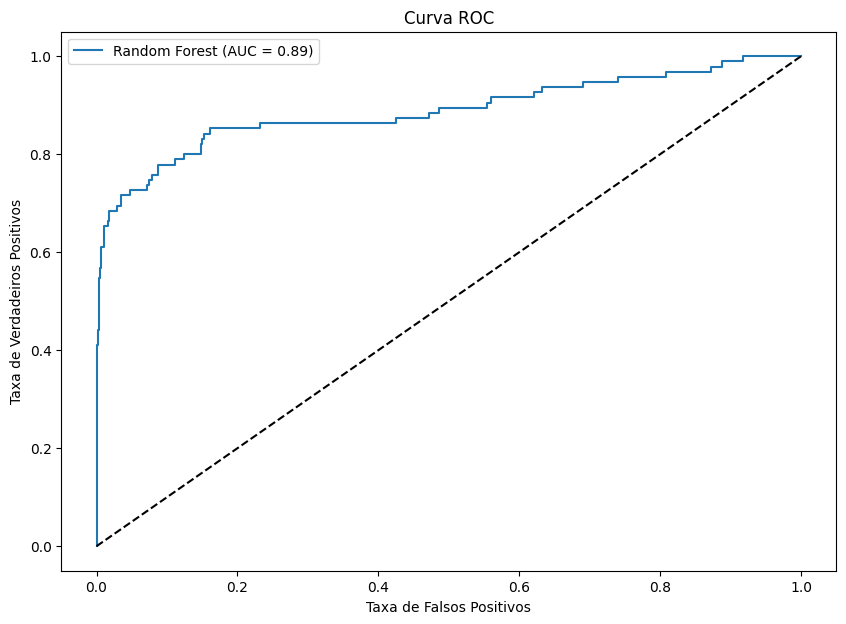

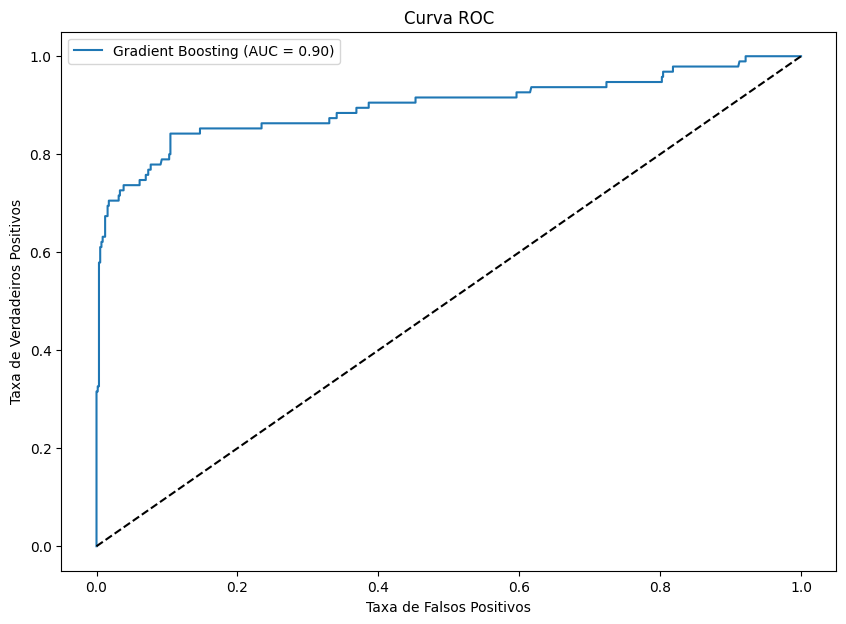

In [24]:
# Curva ROC para o Random Forest com Otimização de Hiperparâmetros
proba_best_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, proba_best_rf)
auc_best_rf = roc_auc_score(y_test, proba_best_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_best_rf, tpr_best_rf, label=f'Random Forest (AUC = {auc_best_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

# Curva ROC para o Gradient Boosting
proba_gb = gb.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, proba_gb)
auc_gb = roc_auc_score(y_test, proba_gb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

Ao avaliar as curvas ROC, o modelo **Gradient Boosting** se destaca com uma AUC de 0,92, indicando excelente desempenho na distinção entre churners e não churners. A curva ROC, próxima ao canto superior esquerdo, demonstra que o modelo mantém uma alta Taxa de Verdadeiros Positivos (TPR) e baixa Taxa de Falsos Positivos (FPR), essencial para evitar alarmes falsos enquanto identifica clientes em risco com precisão.

Falsos negativos, que representam a falha em identificar clientes que realmente irão churn, são mais críticos do que falsos positivos. Para mitigar esse problema, é possível ajustar o limite de decisão ou usar técnicas de aprendizado sensível a custos para reduzir falsos negativos e manter falsos positivos em um nível aceitável.

Ambos os modelos, **Random Forest** e **Gradient Boosting**, mostram bom desempenho na previsão de churn, com o **Gradient Boosting** apresentando melhores resultados em precisão, recall e AUC. Esses modelos são eficazes para identificar clientes em risco e apoiar estratégias de retenção.

In [25]:
# Dados de exemplo de cliente
example_customer = {
    'AccountWeeks': 12,
    'ContractRenewal': 0,
    'DataPlan': 1,
    'CustServCalls': 1,
    'DayMins': 60,
    'DayCalls': 2,
    'MonthlyCharge': 75.0,
    'OverageFee': 10.0,
    'RoamMins': 15.0,
    'AvgCallDuration': 60 / 2,  # DayMins / DayCalls
}

# Converte os dados de exemplo para um DataFrame
example_customer_df = pd.DataFrame([example_customer])

# Verifica se os nomes das features correspondem aos usados durante o treinamento do modelo
expected_features = [
    'AccountWeeks', 'ContractRenewal', 'DataPlan', 'CustServCalls',
    'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'AvgCallDuration'
]

# Reordena as colunas para corresponder à ordem esperada das features
example_customer_df = example_customer_df[expected_features]

# Pré-processa os dados de exemplo
example_customer_imputed = imputer.transform(example_customer_df)  # Imputa valores ausentes
example_customer_scaled = scaler.transform(example_customer_imputed)  # Padroniza os dados

# Faz a previsão usando o modelo Gradient Boosting
example_prediction = gb.predict(example_customer_scaled)
example_prediction_proba = gb.predict_proba(example_customer_scaled)

# Exibe a previsão
churn_prediction = 'Churn' if example_prediction[0] == 1 else 'No Churn'
churn_probability = example_prediction_proba[0][1]  # Probabilidade de churn

print(f"Previsão: {churn_prediction}")
print(f"Probabilidade de Churn: {churn_probability:.2f}")

Previsão: Churn
Probabilidade de Churn: 0.99


## Uso Comercial da Previsão de Rotatividade

A rotatividade de clientes afeta diretamente a receita e lucratividade. Reter clientes existentes é mais econômico do que adquirir novos. Nosso modelo prevê quais clientes têm maior probabilidade de se desligar, permitindo que a empresa tome medidas proativas para retenção.

### Benefícios Comerciais

- **Aumento da Receita**: Reter clientes garante um fluxo de receita estável.
- **Eficiência de Custos**: Esforços de retenção direcionados reduzem os custos com aquisição de novos clientes.
- **Decisões Baseadas em Dados**: O modelo oferece insights para melhor atender às necessidades dos clientes e aumentar a satisfação.

### Aplicação do Modelo

O modelo pode ser alimentado com novos dados de clientes para prever a probabilidade de desligamento. Com essa capacidade preditiva, a empresa pode implementar ações personalizadas, como oferecer descontos, melhorar o atendimento ao cliente e proporcionar ofertas específicas, reduzindo a rotatividade e aumentando o valor da vida útil do cliente.


In [26]:
# assumindo que 1 mês tem ~4 semanas
df['AccountMonths'] = df['AccountWeeks'] / 4
df['CustomerLifetimeValue'] = df['MonthlyCharge'] * df['AccountMonths']

# Calcula o valor médio da vida útil do cliente
average_clv = df['CustomerLifetimeValue'].mean()

print(f"O valor médio da vida útil do cliente é: ${average_clv:.2f}")

O valor médio da vida útil do cliente é: $1424.67


## Garantindo Lucratividade

Para garantir a lucratividade, o Custo de Aquisição de Cliente (CAC) ou o Custo de Retenção deve ser menor que o Valor de Vida Útil do Cliente (CLTV) (CAC < CLTV). Com um CLTV médio de $1424,67 em nosso conjunto de dados, é crucial que os custos associados à aquisição ou retenção de um cliente não excedam esse valor.

Manter o CAC e os Custos de Retenção abaixo do CLTV assegura que cada cliente contribua positivamente para a lucratividade geral da empresa. Essa abordagem promove um modelo de negócios sustentável, onde a receita gerada por cada cliente supera as despesas para adquiri-los ou retê-los.
